In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))  # Go up one directory

from llm_provider import LLM_provider
llm=LLM_provider()
model=llm.get_llm()


In [2]:
from langchain_community.document_loaders import PyPDFLoader
from langchain_chroma import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter 
from langchain.output_parsers import PydanticOutputParser
from pydantic import BaseModel,Field
from typing import TypedDict,Annotated,Sequence
from langchain_core.messages import BaseMessage
import operator
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import (
    RunnablePassthrough
)
from langgraph.graph import StateGraph,START,END,MessagesState
from IPython.display import Image,display
from langchain.agents import tool
from langgraph.prebuilt import ToolNode

In [3]:
#Normal llm invoke used here 

def call_model(state:MessagesState):
    print(state)
    question=state["messages"][0].content
    response=model.invoke(question)
    return {"messages":[response]}

# state={"messages":["Hi how are youy"]}
# call_model(state)


In [4]:
workflow=StateGraph(MessagesState)

In [5]:
workflow.add_node("my_bot",call_model)
workflow.add_edge(START,"my_bot")
workflow.add_edge("my_bot",END)

In [6]:
app=workflow.compile()

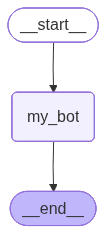

In [7]:
display(Image(app.get_graph().draw_mermaid_png()))

In [8]:
input={"messages":["hi how are you"]}
result=app.invoke(input)
result

{'messages': [HumanMessage(content='hi how are you', additional_kwargs={}, response_metadata={}, id='26f8a4f9-ff77-4793-b477-e65656246db4')]}


{'messages': [HumanMessage(content='hi how are you', additional_kwargs={}, response_metadata={}, id='26f8a4f9-ff77-4793-b477-e65656246db4'),
  AIMessage(content="Hello! I'm just a virtual assistant, so I don't have feelings, but I'm here and ready to help you with whatever you need. How about you? How are you doing? 😊", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 38, 'prompt_tokens': 11, 'total_tokens': 49, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-11-20', 'system_fingerprint': 'fp_3eed281ddb', 'id': 'chatcmpl-CMBl9Ep84PCryu5eC6o5C6wovtgZ7', 'service_tier': None, 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'

In [9]:
for output in app.stream(input,stream_mode="values"):
    for key , val in output.items():
        print(f"Output from {key} Node")
        print("____")
        print(val)
        print("\n")


Output from messages Node
____
[HumanMessage(content='hi how are you', additional_kwargs={}, response_metadata={}, id='04e1e6fd-14a7-4088-a4a4-38d4f899d459')]


{'messages': [HumanMessage(content='hi how are you', additional_kwargs={}, response_metadata={}, id='04e1e6fd-14a7-4088-a4a4-38d4f899d459')]}
Output from messages Node
____
[HumanMessage(content='hi how are you', additional_kwargs={}, response_metadata={}, id='04e1e6fd-14a7-4088-a4a4-38d4f899d459'), AIMessage(content="Hi! I'm just a bunch of code, so I don't have feelings, but I'm here and ready to help you with whatever you need. How about you? How are you doing? 😊", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 39, 'prompt_tokens': 11, 'total_tokens': 50, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-

In [10]:
@tool
def search(query:str):
    '''This is my custom tool node for searching web'''
    if "delhi" in query.lower():
        return "the temp is 45 degree and sunny"
    
    return "the temp is 23 degree and cloudy"
    

In [11]:
search.invoke("what is a temprature in delhi")

'the temp is 45 degree and sunny'

In [12]:
model.invoke("what is the weather in delhi")

AIMessage(content="I'm unable to provide real-time weather updates as my knowledge only goes up until October 2023, and I don't have live data access. To get the current weather in Delhi, you can check a reliable weather website or app like [Weather.com](https://weather.com), [AccuWeather](https://www.accuweather.com), or use your smartphone's weather app.", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 77, 'prompt_tokens': 14, 'total_tokens': 91, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-11-20', 'system_fingerprint': 'fp_3eed281ddb', 'id': 'chatcmpl-CMBlBlzxpFyaNX6oGA6i9G1ky5mO8', 'service_tier': None, 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': Fal

Since the model cannot give real time updates hence this is one of the reason we use tools 

In [13]:
tools=[search]
llm_with_tools=model.bind_tools(tools)

llm_with_tools

RunnableBinding(bound=AzureChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x0000029097AF8F10>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x000002909813E290>, root_client=<openai.lib.azure.AzureOpenAI object at 0x000002909602CF90>, root_async_client=<openai.lib.azure.AsyncAzureOpenAI object at 0x0000029097CCB2D0>, temperature=0.1, model_kwargs={}, openai_api_key=SecretStr('**********'), disabled_params={'parallel_tool_calls': None}, azure_endpoint='https://dqazureaifound6652576421.cognitiveservices.azure.com/', deployment_name='gpt-4o', openai_api_version='2024-12-01-preview', openai_api_type='azure'), kwargs={'tools': [{'type': 'function', 'function': {'name': 'search', 'description': 'This is my custom tool node for searching web', 'parameters': {'properties': {'query': {'type': 'string'}}, 'required': ['query'], 'type': 'object'}}}]}, config={}, config_factories=[])

In [14]:
response=llm_with_tools.invoke("what is the weather in delhi")
response

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_zBugOTkjX9ptM7a8KAisSBnl', 'function': {'arguments': '{"query":"current weather in Delhi"}', 'name': 'search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 53, 'total_tokens': 70, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-11-20', 'system_fingerprint': 'fp_3eed281ddb', 'id': 'chatcmpl-CMBlC4I1gQFYCby0vW7jAztwfxgrl', 'service_tier': None, 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'saf

In [15]:
# AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_JlKD9AkjGPejIjusNyLUrfy7', 'function': {'arguments': '{"query":"current weather in Delhi"}', 'name': 'search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 53, 'total_tokens': 70, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-11-20', 'system_fingerprint': 'fp_ee1d74bde0', 'id': 'chatcmpl-CL98XflaGIJIt0qMTdDNT62dvwSRE', 'service_tier': None, 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'tool_calls', 'logprobs': None, 'content_filter_results': {}}, id='run--c626dbaa-3d99-423b-b605-306edf294dae-0', tool_calls=[{'name': 'search', 'args': {'query': 'current weather in Delhi'}, 'id': 'call_JlKD9AkjGPejIjusNyLUrfy7', 'type': 'tool_call'}], usage_metadata={'input_tokens': 53, 'output_tokens': 17, 'total_tokens': 70, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [16]:
response.tool_calls

[{'name': 'search',
  'args': {'query': 'current weather in Delhi'},
  'id': 'call_zBugOTkjX9ptM7a8KAisSBnl',
  'type': 'tool_call'}]

---

In [17]:
tools=[search]
llm_with_tools=model.bind_tools(tools)

llm_with_tools

RunnableBinding(bound=AzureChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x0000029097AF8F10>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x000002909813E290>, root_client=<openai.lib.azure.AzureOpenAI object at 0x000002909602CF90>, root_async_client=<openai.lib.azure.AsyncAzureOpenAI object at 0x0000029097CCB2D0>, temperature=0.1, model_kwargs={}, openai_api_key=SecretStr('**********'), disabled_params={'parallel_tool_calls': None}, azure_endpoint='https://dqazureaifound6652576421.cognitiveservices.azure.com/', deployment_name='gpt-4o', openai_api_version='2024-12-01-preview', openai_api_type='azure'), kwargs={'tools': [{'type': 'function', 'function': {'name': 'search', 'description': 'This is my custom tool node for searching web', 'parameters': {'properties': {'query': {'type': 'string'}}, 'required': ['query'], 'type': 'object'}}}]}, config={}, config_factories=[])

In [18]:
tools

[StructuredTool(name='search', description='This is my custom tool node for searching web', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x0000029095A94680>)]

In [19]:
tool_node=ToolNode(tools)
tool_node

tools(tags=None, recurse=True, explode_args=False, func_accepts={'config': ('N/A', <class 'inspect._empty'>), 'store': ('store', None)}, tools_by_name={'search': StructuredTool(name='search', description='This is my custom tool node for searching web', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x0000029095A94680>)}, tool_to_state_args={'search': {}}, tool_to_store_arg={'search': None}, handle_tool_errors=True, messages_key='messages')

User: "What's the weather?"
#    ↓
[agent node] → llm_with_tools thinks → AIMessage(tool_calls=[search(...)])
#    ↓
[tools node] → ToolNode executes → ToolMessage(result="Sunny, 72°F")
    ↓
#[agent node] → llm_with_tools reads result → AIMessage("The weather is sunny!")
#    ↓
User gets final answer

In [ ]:
def llm_model_with_tool(state:MessagesState):
    # question=state["messages"][0].content
    # print("inside llm with tool fucntion")
    # print("state is ",state["messages"])
    question=state["messages"]
    ''''use this when we are invoking as langgraph converts this ['hi how are you'] into this 
    input = {"messages": [HumanMessage(content="hi how are you")]}
    '''
    response=llm_with_tools.invoke(question)
    return {"messages":[response]}



In [72]:
def router_func(state:MessagesState):
    last_message=state["messages"][-1]
    if last_message.tool_calls:
        return "tools"
    return END

In [73]:
workflow2=StateGraph(MessagesState)

In [74]:
workflow2.add_node("llm_with_tool",llm_model_with_tool)

In [75]:
workflow2.add_node("mytools",tool_node)

In [ ]:
workflow2.add_edge(START,"llm_with_tool")
workflow2.add_conditional_edges(
    "llm_with_tool",
    router_func,{
        "tools":"mytools",
        END:END
    }

    )
workflow2.add_edge("mytools", "llm_with_tool")  

In [77]:
app2=workflow2.compile()

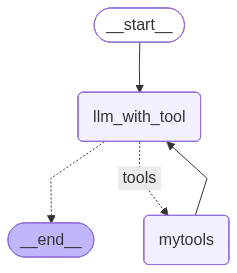

In [78]:
display(Image(app2.get_graph().draw_mermaid_png()))

In [79]:
result=app2.invoke({"messages":["hi how are you"]})

In [80]:
result["messages"]

[HumanMessage(content='hi how are you', additional_kwargs={}, response_metadata={}, id='8c868025-00ef-40bc-9941-8e43974e7238'),
 AIMessage(content="Hello! I'm just a program, so I don't have feelings, but I'm here and ready to help you with anything you need. How about you? How are you doing?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 37, 'prompt_tokens': 50, 'total_tokens': 87, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-11-20', 'system_fingerprint': 'fp_3eed281ddb', 'id': 'chatcmpl-CMByRlcfaWsr5no0UGQMXQJCn8vem', 'service_tier': None, 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severit

In [ ]:
for output in app2.stream({"messages":["What is the weather in banglore"]}):
    for key, val in output.items():
        print(f"here is the output from {key}")
        print("____")
        print(val)
        print("\n")


here is the output from llm_with_tool
____
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_2oFwOH9aGkEmuDRe1p18rlas', 'function': {'arguments': '{"query":"current weather in Bangalore"}', 'name': 'search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 54, 'total_tokens': 71, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-11-20', 'system_fingerprint': 'fp_3eed281ddb', 'id': 'chatcmpl-CMCYLUidGItueiG1VIp1Fg4jtClz5', 'service_tier': None, 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severit

In [90]:
from langgraph.checkpoint.memory import MemorySaver
memory=MemorySaver()

In [85]:
config={"configurable":{"thread_id":"1"}}

In [88]:
events=app2.stream({"messages":["What is the weather in banglore"]},config=config,stream_mode="values")


In [89]:
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is the weather in banglore
================================== Ai Message ==================================
Tool Calls:
  search (call_90PiK6wg3E1ubyrJkr4mt7Uz)
 Call ID: call_90PiK6wg3E1ubyrJkr4mt7Uz
  Args:
    query: current weather in Bangalore
================================= Tool Message =================================
Name: search

the temp is 23 degree and cloudy
================================== Ai Message ==================================

The current temperature in Bangalore is 23°C, and the weather is cloudy.


In [ ]:
memory.get(config)